      communityname state  countyCode  communityCode  fold  population  \
0    Marpletownship    PA        45.0        47616.0     1       23123   
1        Tigardcity    OR         NaN            NaN     1       29344   
2  Gloversvillecity    NY        35.0        29443.0     1       16656   
3       Bemidjicity    MN         7.0         5068.0     1       11245   
4   Springfieldcity    MO         NaN            NaN     1      140494   

   householdsize  racepctblack  racePctWhite  racePctAsian  ...  burglaries  \
0           2.82          0.80         95.57          3.44  ...        57.0   
1           2.43          0.74         94.33          3.43  ...       274.0   
2           2.40          1.70         97.35          0.50  ...       225.0   
3           2.76          0.53         89.16          1.17  ...        91.0   
4           2.45          2.51         95.65          0.90  ...      2094.0   

   burglPerPop  larcenies  larcPerPop  autoTheft  autoTheftPerPop  arsons  \
0  

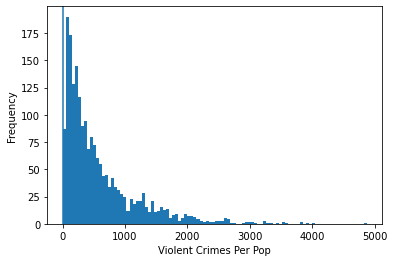

223.06     3
624.31     2
115.14     2
28.45      2
84.88      2
          ..
116.10     1
280.44     1
154.77     1
974.36     1
2089.32    1
Name: ViolentCrimesPerPop, Length: 1972, dtype: int64
variables    population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0       23123           2.82          0.80         95.57          3.44   
1       29344           2.43          0.74         94.33          3.43   
2       16656           2.40          1.70         97.35          0.50   
3       11245           2.76          0.53         89.16          1.17   
4      140494           2.45          2.51         95.65          0.90   

   racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0         0.85        11.01        21.30        10.48       17.18  ...   
1         2.35        11.36        25.88        11.01       10.28  ...   
2         0.70        12.55        25.20        12.19       17.57  ...   
3         0.52        24.46        40.53        28.6

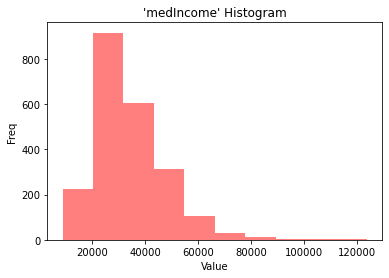

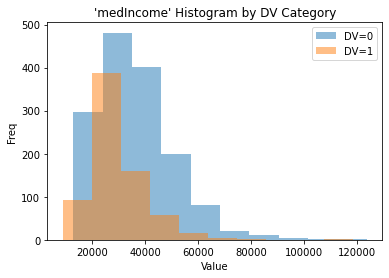

In [13]:
%run Preprocessing.ipynb

In [28]:
# Import packages
import sklearn.feature_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV # RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import pandas as pd

In [15]:
# Split the data into training and test data sets using sklearn.model_selection
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.70, random_state=1)

# check the dataset to see how much the dataset has grown (if dimenstionality was increased)
print(data.shape)
print(x.shape)

(2214, 104)
(2214, 103)


**Feature Selection**
- Build the model using the pre-processed data

In order to avoid overfitting and slow computing (due to the increase in features from dummying as well as increasing dimensionality), selecting the most important features is important. 


In [16]:
# select k best is a univariate method for feature selection:
# looks at the outcome and the relationship with each feature and selects k number of best features 
select = sklearn.feature_selection.SelectKBest(k=20)
selected_features = select.fit(x_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [x.columns[I] for I in indices_selected]

x_train_selected = x_train[colnames_selected]
x_test_selected = x_test[colnames_selected]

colnames_selected # 20 features selected

['racepctblack',
 'racePctWhite',
 'pctWInvInc',
 'pctWPubAsst',
 'PctPopUnderPov',
 'PctNotHSGrad',
 'PctUnemployed',
 'MalePctDivorce',
 'FemalePctDiv',
 'TotalPctDiv',
 'PctFam2Par',
 'PctKids2Par',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'PctKidsBornNeverMar',
 'PctLargHouseFam',
 'PctPersOwnOccup',
 'PctPersDenseHous',
 'PctVacantBoarded',
 'PctHousNoPhone']

**Build Decision tree #1**

Firstly, we create a basic DecisionTreeClassifier, and then will slowly tune the parameters, firstly, we need to look at the **max depth**. The cell below will calcaulate the accuracy score for a max depth up to *n*. This is then plotted in a bar graph.

In [65]:
# Max depth hyper parameter choice plot
def max_depth(n):
    scores = {}
    for i in range(3, n):
        dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)  # use the entropy rather than gini index
        dtree = dtree.fit(x_train, y_train)
        #tree.plot_tree(dtree, feature_names=data.columns) 

        # model can then be used to predict !
        # crime_predict = dtree.predict([[0,1]])

        # Assess accuracy at this stage
        clf = DecisionTreeClassifier()  # Create Decision Tree classifer object
        clf = clf.fit(x_train,y_train)  # Train Decision Tree Classifer
        y_pred = clf.predict(x_test)  # Predict the response for test dataset
        #print(i, "max_depth::", "Accuracy:",metrics.accuracy_score(y_test, y_pred))
        j = str(i)
        depth_score = {j: metrics.accuracy_score(y_test, y_pred)}
        scores.update(depth_score)
    return scores
d = max_depth(10)
import matplotlib.pyplot as plt
colors = list("rgbcmyk")

for key in d:
    plt.bar([key], d[key], label=key)

plt.title('Max Depth vs Test Data Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.ylim(0.675, 0.750)
plt.show()

For this dataset, we have shown that the max_depth at 5 provides the highest accuracy. Therefore, the current model is:

In [104]:
dtree = DecisionTreeClassifier(criterion='gini', max_depth=5)  # use the entropy rather than gini index
dtree = dtree.fit(x_train, y_train)
#tree.plot_tree(dtree, feature_names=data.columns) 

# model can then be used to predict !
# crime_predict = dtree.predict([[0,1]])

y_pred = dtree.predict(x_test)  # Predict the response for test dataset
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7323308270676692


**K-Fold Classification** 
This will increase the number of times the test and train data is split, then will average out the accuracy scores. The cells below will increase the number of K up to 12, then plot the accuracy for the data.

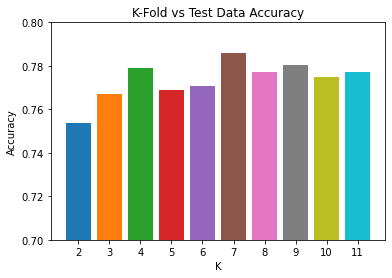

In [95]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score


kfold_scores = {}
for i in range(2,12):
    kf =KFold(n_splits=i, shuffle=True, random_state=42)
    score = cross_val_score(tree.DecisionTreeClassifier(criterion='gini', max_depth=5), x, y, cv= kf, scoring="accuracy")
    #print(f'Scores for each fold are: {score}')
    #print(f'Number of folds = {i} Average score: {"{:.2f}".format(score.mean())}')
    res = {str(i): score.mean()}
    kfold_scores.update(res)

for key in kfold_scores:
    plt.bar([key], kfold_scores[key], label=key)

plt.title('K-Fold vs Test Data Accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.8)
plt.show()

Therefore, the updated with model with optimized k and max_depth is:

In [101]:
kf =KFold(n_splits=7, shuffle=True, random_state=42)
score = cross_val_score(tree.DecisionTreeClassifier(criterion='gini', max_depth=5), x, y, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.75709779 0.81072555 0.76582278 0.80696203 0.79113924 0.79746835
 0.7721519 ]
Average score: 0.79


In [6]:
# most stylised tree:
# import graphviz
# dot_data = tree.export_graphviz(dtree, out_file=None, feature_names=features, filled=True, rounded=True, special_characters=True)
# graph = graphviz.Source(dot_data)
# graph

code adapted from https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

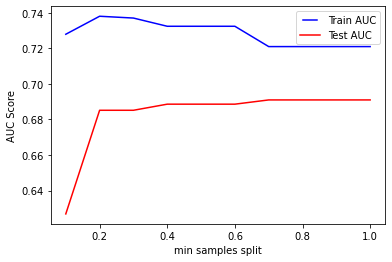

In [117]:
import numpy as np
from sklearn.metrics import roc_curve, auc

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('min samples split')
plt.show()

In [124]:
x_test.shape

(665, 103)

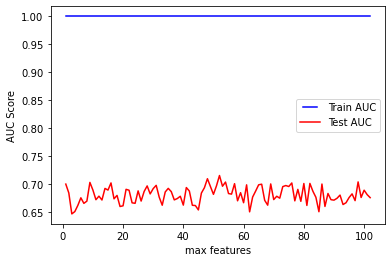

In [130]:
max_features = list(range(1,x_train.shape[1]))

train_results = []
test_results = []

for max_feature in max_features:
   dt = DecisionTreeClassifier(max_features=max_feature)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('max features')
plt.show()

In [147]:
kf =KFold(n_splits=7, shuffle=True, random_state=42)
score = cross_val_score(tree.DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split = 0.2, max_features=54), x, y, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.7444795  0.80126183 0.71518987 0.80379747 0.79113924 0.79746835
 0.7943038 ]
Average score: 0.78


**Build the Decision tree #2** - applying pre-pruning techniques

In [107]:
# Testing pre pruning

params = {'max_depth': [2,4,6,8,10,12],  # why did we select these parameters?
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

clf = DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv = gcv.fit(x_train,y_train)
y_pred = gcv.predict(x_test)  # Predict the response for test dataset
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) # better accuracy score

Accuracy: 0.7308270676691729


Train score 0.855390574564235
Test score 0.7368421052631579
Train Confusion matrix


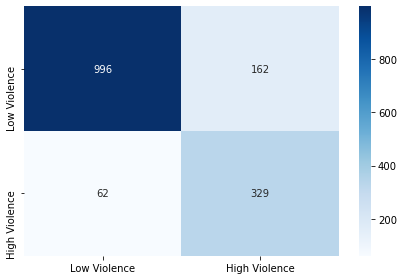

Test Confusion matrix


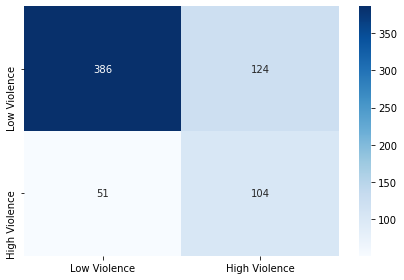

In [112]:
# Pre-pruning summary
classes = ['Low Violence', 'High Violence']
def plot_confusionmatrix(train_pred, train, dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(train_pred,train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
    
# model = gcv.best_estimator_
# model.fit(x_train,y_train)
model = tree.DecisionTreeClassifier(criterion='gini', max_depth=5)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

**Build Decision Tree #3** - applying post-pruning techniques

https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

Total impurity of leaves vs effective alphas of pruned tree:

Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first.

Scikit-learn provides DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

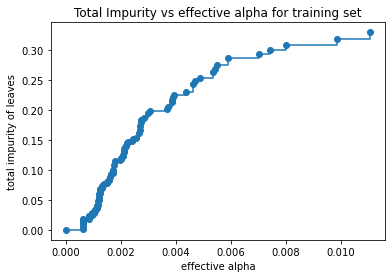

In [28]:
# 1. Cost complexity pruning path
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# Plot
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
# the maximum effective alpha value is removed, because it is the trivial tree with only one node.


In [29]:
# 2. Train a decision tree using the effective alphas.
# The last value in ccp_alphas is the alpha value that prunes the whole tree, 
# this leaves the tree (clfs[-1]) with one node.

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.1028282003523327


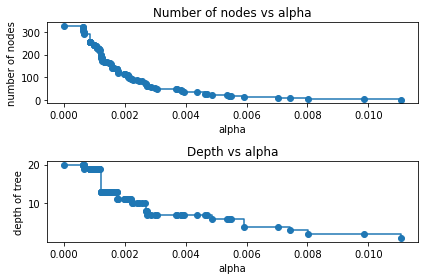

In [15]:
# 3. Remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node.
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# Show that the number of nodes and tree depth decreases as alpha increases.
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

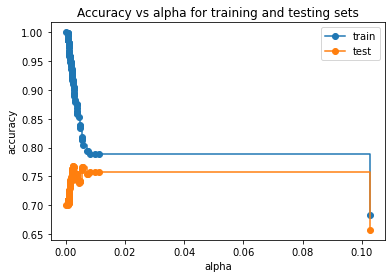

In [32]:
# 4. Compare accuracy vs alpha for training
# When ccp_alpha is set to zero, the tree overfits; leading to a 100% training accuracy and 88% testing accuracy.
# As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. 

train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [11]:
# fit the model again with the most suitable alpha i.e. 0.008
# this alpha achieves the best test accuracy

tree = DecisionTreeClassifier(ccp_alpha=0.01, random_state=40)
tree.fit(x_train, y_train)
y_train_pred=tree.predict(x_train)
y_test_pred=tree.predict(x_test)

print("Pruned tree train accuracy score: ", accuracy_score(y_train, y_train_pred),
"Pruned tree test accuracy score: ", accuracy_score(y_test, y_test_pred))

Pruned tree train accuracy score:  1.0 Pruned tree test accuracy score:  1.0


In [14]:
# extra graphs needed 
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html
    